Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

Reading dataset

In [2]:
dataset = pd.read_excel('Superstore.xls')
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Creating dataset for each categories with excluding other columns 

In [3]:
set(dataset['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

In [4]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
office = dataset.loc[dataset['Category'] == 'Office Supplies']
technology = dataset.loc[dataset['Category'] == 'Technology']

In [5]:
def del_col(catg):
    cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 
            'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
            'Product Name', 'Quantity', 'Discount', 'Profit']
    catg.drop(cols, axis=1, inplace=True)
    
del_col(technology)
del_col(furniture)
del_col(office)

C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
furniture = furniture.set_index('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.sort_values('Order Date')
furniture = furniture.set_index('Order Date')

office = office.set_index('Order Date')
office = office.groupby('Order Date')['Sales'].sum().reset_index()
office.sort_values('Order Date')
office = office.set_index('Order Date')

technology = technology.set_index('Order Date')
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
technology.sort_values('Order Date')
technology = technology.set_index('Order Date')

Dates in dataset though contain noise and unsignificance correlation <br>
Hence converting day wise to monthly time series along with 

In [7]:
furniture = furniture['Sales'].resample('MS').mean()
technology = technology['Sales'].resample('MS').mean()
office = office['Sales'].resample('MS').mean()

In [8]:
technology[12:24]

Order Date
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
Freq: MS, Name: Sales, dtype: float64

C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


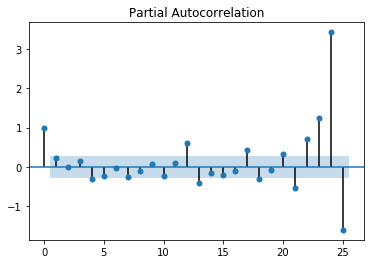

In [9]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(furniture, lags=25)
pyplot.show()

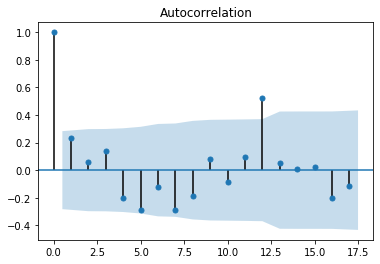

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(furniture)
pyplot.show()

Model contain seasonality 

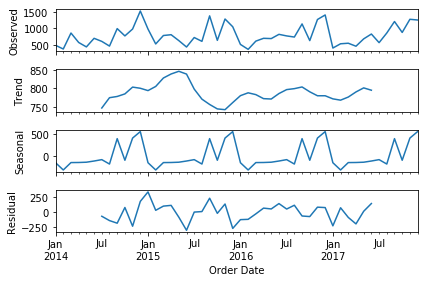

In [11]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(furniture, model='additive')
decomposition.plot()
plt.show()

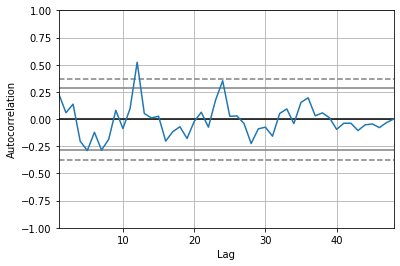

In [12]:
autocorrelation_plot(furniture)
pyplot.show()

Forcasting dataset with *SARIMA (Seasonal AutoRegressive Integrated Moving Average)* model as Seasonality exist<br>
To avoid noise or unsignificance result configuring hyperparameters for both the trend and seasonal components of the series.<br>
SARMIA model consist of 7 hyperparameters in which first three are:<br>
*Trend Elements*<br>
They are the same as the ARIMA model:<br>
    p: Trend autoregression order.<br>
    d: Trend difference order.<br>
    q: Trend moving average order.<br>

And the remaining four are:<br>
*Seasonal Elements*<br>
There are four seasonal elements that are not part of ARIMA that must be configured:<br>
    P: Seasonal autoregressive order.<br>
    D: Seasonal difference order.<br>
    Q: Seasonal moving average order.<br>
    m: The number of time steps for a single seasonal period.<br>

In [13]:
# Iterating numbers from 0 - 2 for hyperparameter tuning 
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]    # m = 12, as seasonal period is yearly 

In [14]:
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [15]:
print(seasonal_pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [16]:
# Parameter Tuning
for para in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(furniture, order=para, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, # as data is already stationery 
                                              enforce_invertibility=False) # set both as false
            result = model.fit()
            print('ARIMA {}x{} - AIC:{}'.format(para, param_seasonal, result.aic))
        except:
            continue

ARIMA (0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205916


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0)x(0, 0, 1, 12) - AIC:1576.7324642473277
ARIMA (0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774
ARIMA (0, 0, 0)x(1, 0, 0, 12) - AIC:497.23144334183365


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0)x(1, 0, 1, 12) - AIC:1478.1277236759956
ARIMA (0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA (0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758104
ARIMA (0, 0, 1)x(0, 0, 1, 12) - AIC:2786.7230874852653
ARIMA (0, 0, 1)x(0, 1, 0, 12) - AIC:466.56074298091505


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1)x(1, 0, 0, 12) - AIC:499.59412606125284
ARIMA (0, 0, 1)x(1, 0, 1, 12) - AIC:2768.427220528199
ARIMA (0, 0, 1)x(1, 1, 0, 12) - AIC:319.98848769468674
ARIMA (0, 1, 0)x(0, 0, 0, 12) - AIC:677.894766843944


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0)x(0, 0, 1, 12) - AIC:1378.5486237111134
ARIMA (0, 1, 0)x(0, 1, 0, 12) - AIC:486.63785671879367
ARIMA (0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0)x(1, 0, 1, 12) - AIC:1022.8611228052164
ARIMA (0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA (0, 1, 1)x(0, 0, 0, 12) - AIC:649.905617681726
ARIMA (0, 1, 1)x(0, 0, 1, 12) - AIC:3216.0197782079413
ARIMA (0, 1, 1)x(0, 1, 0, 12) - AIC:458.8705548482984
ARIMA (0, 1, 1)x(1, 0, 0, 12) - AIC:486.1832977442631


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1)x(1, 0, 1, 12) - AIC:2589.717123007444
ARIMA (0, 1, 1)x(1, 1, 0, 12) - AIC:310.7574368417452
ARIMA (1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067713


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0)x(0, 0, 1, 12) - AIC:1450.0255396955233
ARIMA (1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355
ARIMA (1, 0, 0)x(1, 0, 0, 12) - AIC:480.92593679351836


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0)x(1, 0, 1, 12) - AIC:1352.209230823926
ARIMA (1, 0, 0)x(1, 1, 0, 12) - AIC:304.46646750845986
ARIMA (1, 0, 1)x(0, 0, 0, 12) - AIC:665.779444218529


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1)x(0, 0, 1, 12) - AIC:2688.1953106578308
ARIMA (1, 0, 1)x(0, 1, 0, 12) - AIC:468.3685195814159
ARIMA (1, 0, 1)x(1, 0, 0, 12) - AIC:482.57633238765646


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1)x(1, 0, 1, 12) - AIC:nan
ARIMA (1, 0, 1)x(1, 1, 0, 12) - AIC:306.01560022074426
ARIMA (1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0)x(0, 0, 1, 12) - AIC:1455.1241321469415
ARIMA (1, 1, 0)x(0, 1, 0, 12) - AIC:479.20034222811347
ARIMA (1, 1, 0)x(1, 0, 0, 12) - AIC:475.34036587849016


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0)x(1, 0, 1, 12) - AIC:1356.0287228411075
ARIMA (1, 1, 0)x(1, 1, 0, 12) - AIC:300.62709013453934
ARIMA (1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019835137
ARIMA (1, 1, 1)x(0, 0, 1, 12) - AIC:21749.90908195544
ARIMA (1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687610251
ARIMA (1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660837


C:\Users\prasad\Anaconda3\envs\tensorflow9\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1)x(1, 0, 1, 12) - AIC:2592.9586233250657
ARIMA (1, 1, 1)x(1, 1, 0, 12) - AIC:297.787543953291


*Akaike Information Criterion (AIC)* is an estimator of the relative quality of statistical models.<br>
AIC estimates the quality of each model, relative to each of the other models.<br>
In short AIC provides mean for model selection.<br>
Hence less the value is more good the model is.<br>

In [17]:
# Training ARIMA model
model = sm.tsa.statespace.SARIMAX(furniture, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False,
        enforce_invertibility=False)

results = model.fit()

### Model Forcast
To evaluate the model results, we will compare actual sales with the predicted sales of the time series data starting from 2016/07/01 till the end of the data.

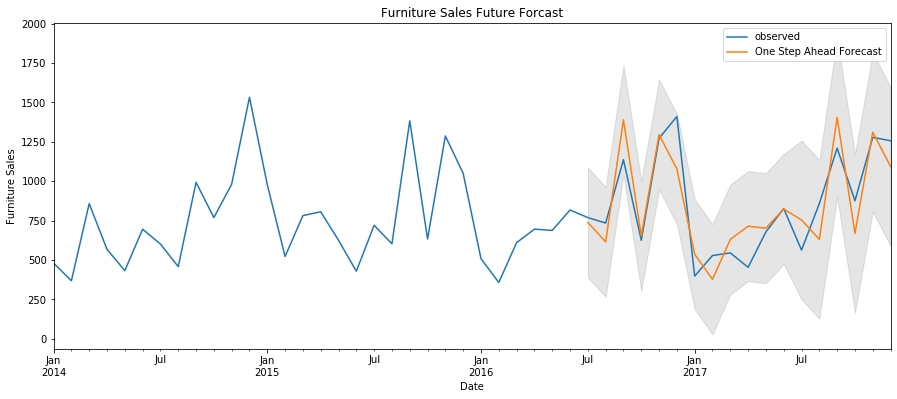

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2016-7-1'), dynamic=True)
pred_ci = pred.conf_int()    # Returns confidence interval of fitted parameters
ax = furniture['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One Step Ahead Forecast', figsize=(15, 6))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.1) #for shaded region
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.title("Furniture Sales Future Forcast")
plt.legend()
plt.show()

### Predicting Future Values

In [19]:
#Training 
model = sm.tsa.statespace.SARIMAX(furniture, order=(1,1,1), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()

In [20]:
#Prediction
pred = model_fit.predict(start="2017-11-1", end="2019-1-1",dynamic=True)

Text(0.5, 1.0, 'Future Predictions for Furniture Sales')

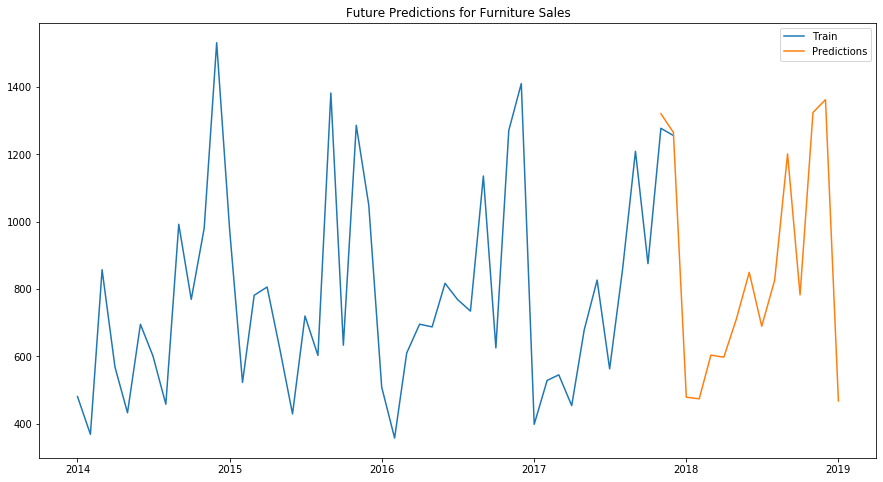

In [21]:
plt.figure(figsize=(15,8))
plt.plot(furniture, label = "Train")
plt.plot(pred, label ="Predictions")
plt.legend(loc = "best")
plt.title("Future Predictions for Furniture Sales")

### Visualizing Furniture Sales vs Office Supplies vs Technology sales

Creating dataframe including values of all categories with respect to date

In [22]:
furniture = pd.DataFrame({'Order Date':furniture.index, 'Sales':furniture.values})
office = pd.DataFrame({'Order Date': office.index, 'Sales': office.values})
technology = pd.DataFrame({'Order Date': technology.index, 'Sales': technology.values})

In [23]:
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store = store.merge(technology, how='inner', on='Order Date')
store.rename(columns={'Sales': 'technology_sales'}, inplace=True)

In [24]:
store.head()

,Order Date,furniture_sales,office_sales,technology_sales
0,2014-01-01,480.194231,285.357647,449.041429
1,2014-02-01,367.931600,63.042588,229.787143
2,2014-03-01,857.291529,391.176318,2031.948375
3,2014-04-01,567.488357,464.794750,613.028933
4,2014-05-01,432.049187,324.346545,564.698588


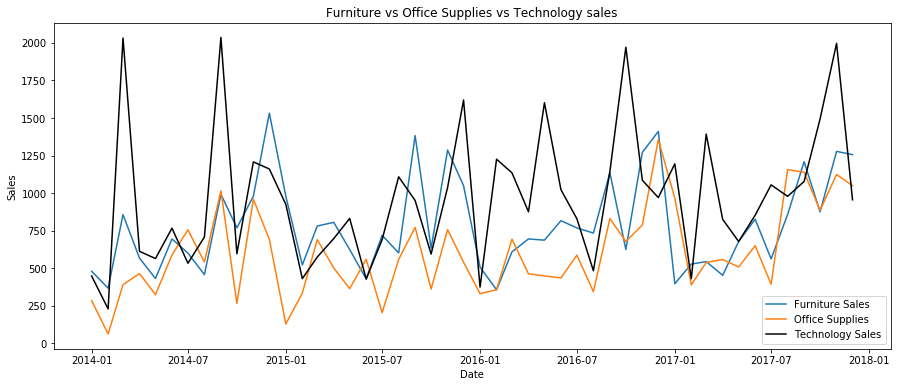

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['furniture_sales'], label='Furniture Sales')
plt.plot(store['Order Date'], store['office_sales'], label='Office Supplies')
plt.plot(store['Order Date'], store['technology_sales'], label='Technology Sales',color='black')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies vs Technology sales')
plt.legend()

From the above plot results can be interpreted that Technology have highest number of sales <br>
Compared to Furniture and Office Sales